In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()

2022-04-22 16:54:05.277917: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 16:54:05.277957: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


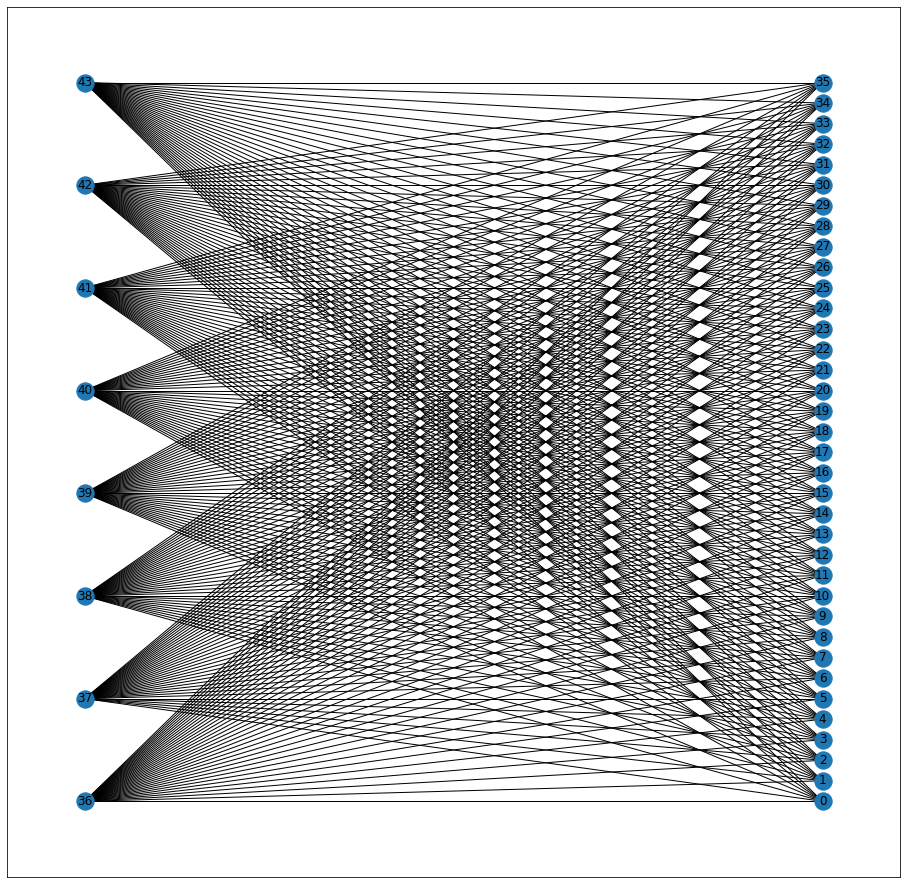

In [2]:
num_visible = 36
num_hidden = 8

visible = [i for i in range(num_visible)]
hidden = [num_visible + j for j in range(num_hidden)]
edges = [(i,j) for i in visible for j in hidden]

G = nx.Graph()
G.add_edges_from(edges)
plt.figure(3, figsize=(16,16))
nx.draw_networkx(G, nx.bipartite_layout(G, nodes=hidden))
plt.show()

In [3]:
from active_coresets.qmc_tim_qbm import QMC_TIM_QBM
import scipy.stats as stats

In [4]:
data = pkl.load(open('bas_data.pkl', 'rb'))
img_shape = (data.shape[1], data.shape[2])
data = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))

In [5]:
data = -2 * data + np.ones(data.shape)

In [6]:
gamma = 2.0

# set the number of mini-batches per epoch
NUM_MINI_BATCHES = 64

# set the number of epochs
NUM_EPOCHS = 2

# set the number of repetitions
NUM_REPS = 1

# set the number of training steps
NUM_TRAINS = NUM_MINI_BATCHES * NUM_EPOCHS

In [7]:
init_weights = np.random.normal(scale=.01, size=(len(visible), len(hidden))).astype(np.float32)
init_biases = np.zeros(len(visible) + len(hidden)).astype(np.float32)
pv_biases = -0.5 * (data.mean(axis=0) - 1)
init_v_biases = np.log(pv_biases / (np.ones(pv_biases.shape[0]) - pv_biases))
init_biases[:len(visible)] = init_v_biases
gammas = np.ones(len(visible) + len(hidden)) * gamma

init_params = {'gammas': gammas.astype(np.float32),
               'biases': init_biases,
               'weights': init_weights}

quantum_lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(2e-2, 500, power=0.5)

params = dict(batch_size=32, m_b_p=0.9, m_b_m=8, num_test_samples=64,
              qbm_optimizer=tf.optimizers.Adam(learning_rate=quantum_lr_schedule, beta_1=0.5, beta_2=0.9).get_config())

In [8]:
def inception_score(model_data):

    inception_model = keras.models.load_model('bas_model')

    total_score = 0.0
    for sample in model_data:
        prediction = inception_model.predict(sample.reshape(1, model_data.shape[1]))
        total_score += prediction[0][0]
    return total_score

2022-04-22 16:54:17.009057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-22 16:54:17.009208: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 16:54:17.009252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-22 16:54:17.009282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-22 16:54:17.032448: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


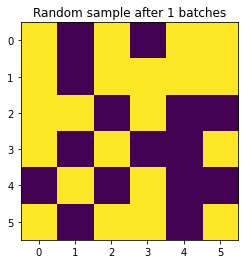

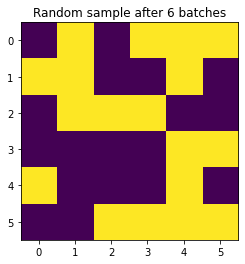

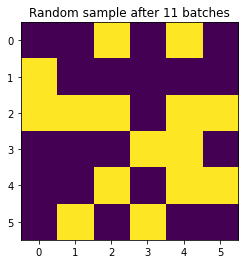

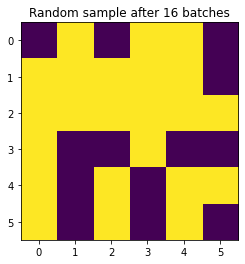

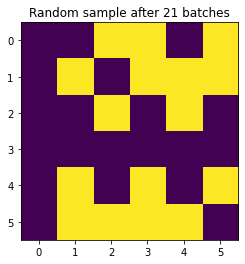

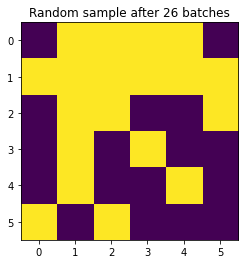

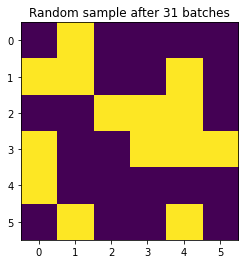

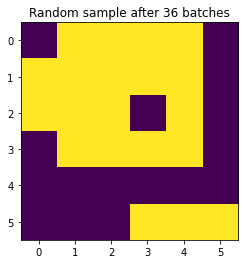

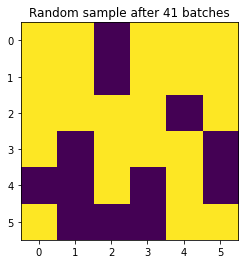

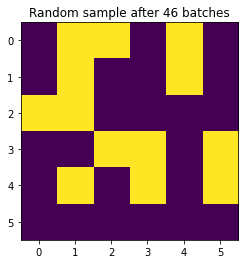

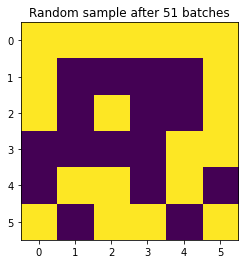

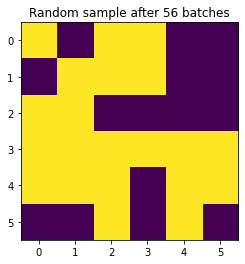

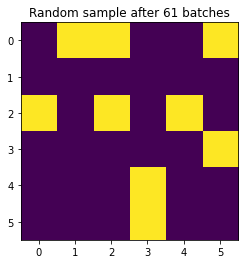

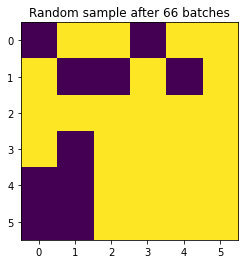

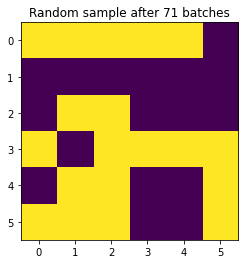

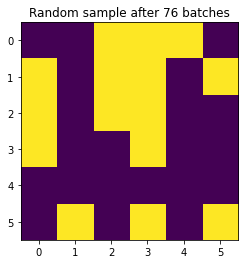

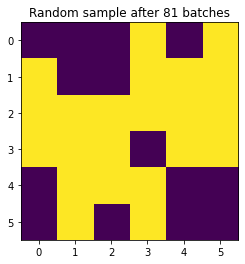

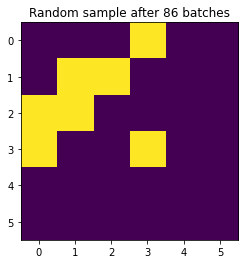

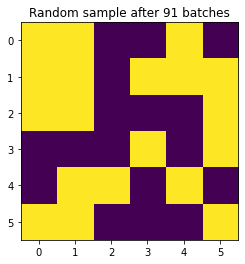

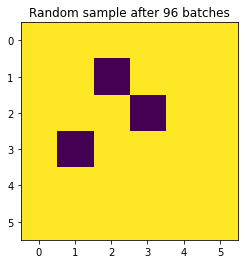

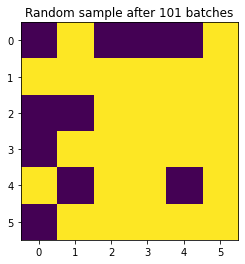

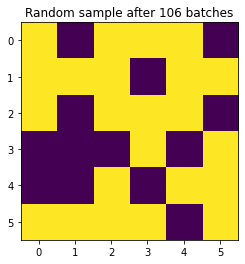

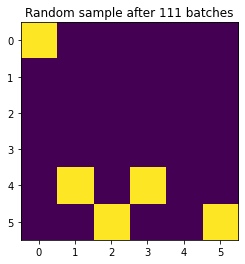

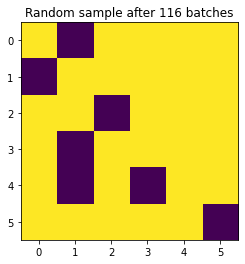

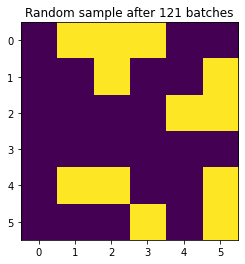

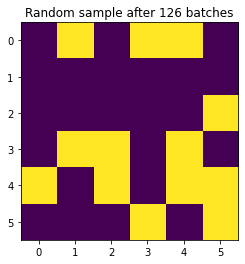

In [9]:
tf.compat.v1.reset_default_graph()

qmc_qbm_samples = []
qmc_qbm_params = [{} for _ in range(NUM_TRAINS)]
qmc_qbm = QMC_TIM_QBM(visible, hidden, initial_params=init_params, num_replicas=64, betas=np.linspace(0, 1, 5).astype(np.float32))

qmc_qbm_mini_batches = QMC_TIM_QBM.mini_batch_generator(data.astype(np.float32), NUM_EPOCHS, batch_size=params['batch_size'])

qmc_qbm_train_op = qmc_qbm.train_op(qmc_qbm_mini_batches, tf.optimizers.Adam.from_config(params['qbm_optimizer']))

with tf.control_dependencies([qmc_qbm_train_op]):
    qmc_qbm_random_samples = qmc_qbm.random_samples(num_samples=params['num_test_samples'])

with tf.compat.v1.train.MonitoredTrainingSession() as sess:
    for mini_batch_index in range(NUM_TRAINS):
        _, random_samples = sess.run([qmc_qbm_train_op, qmc_qbm_random_samples])
        model_data = random_samples[:, :num_visible]
        qmc_qbm_samples.append(model_data)
        qmc_qbm_params[mini_batch_index] = sess.run(qmc_qbm.params)
        if mini_batch_index % 5 == 0:
            plt.clf()
            plt.title(f'Random sample after {mini_batch_index + 1} batches')
            plt.imshow(model_data[0].reshape(img_shape))
            plt.show()

In [10]:
score_history = np.zeros(NUM_TRAINS)
for i in range(NUM_TRAINS):
    score_history[i] = inception_score(qmc_qbm_samples[i])

/home/jviszlai/Documents/Research/coresets/coresets/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


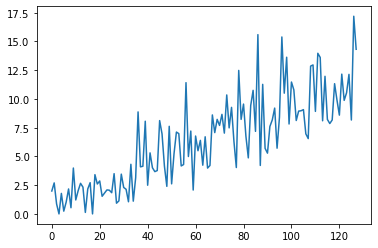

In [11]:
plt.clf()
plt.plot(range(NUM_TRAINS), score_history)

In [12]:
pkl.dump(qmc_qbm_samples, open('bas_results/test-64/samples.pkl', 'wb'))
pkl.dump(score_history, open('bas_results/test-64/scores.pkl', 'wb'))
pkl.dump(qmc_qbm_params, open('bas_results/test-64/params.pkl', 'wb'))